# Trading Strategy

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import os
import seaborn as sns
import random 
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import ensemble

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
os.chdir('/Users/maris/Documents/FE800')

## Import Data

In [7]:
df = pd.read_pickle("df_full.pkl")
df = df.drop(["902613AY4", "785592AS5", "79466LAF1", "785592AU0", "47233JBH0", "47233JAG3"], axis = 0)
df.head()

Price    Volume  Trades    Return       Age        TTM  \
cusip     trd_dt                                                                
00206RBH4 2018-07-02  86.132 -0.175980    13.0  0.000000  5.041096  24.471233   
          2018-07-03  86.821 -0.785507     7.0  0.007999  5.043836  24.468493   
          2018-07-05  86.730 -0.573559    24.0 -0.001048  5.049315  24.463014   
          2018-07-06  88.675 -0.637707    11.0  0.022426  5.052055  24.460274   
          2018-07-09  89.397 -0.115591     7.0  0.008142  5.060274  24.452055   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-02      0.000000      0.043275    0.000000       NaN   
          2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   

                           YTM   Duration      DV01   Convexity RunningCoupon  \
cusip     trd_dt                                                                
00206RBH4 2018-07-02  0.054010  16.324665 -1.406076  339.273017          0.05   
          2018-07-03  0.053445  16.343155 -1.418929  339.790490          0.05   
          2018-07-05  0.053541  16.344714 -1.417577  339.812463          0.05   
          2018-07-06  0.051959  16.349071 -1.449754  339.925850          0.05   
          2018-07-09  0.051410  16.326755 -1.459563  339.254704          0.05   

                     ParSpread CDSRealRecovery UpfrontBASpreadAverage  \
cusip     trd_dt                                                        
00206RBH4 2018-07-02  0.001845             0.4               0.009223   
          2018-07-03  0.001806             0.4               0.007907   
          2018-07-05  0.001819             0.4               0.009406   
          2018-07-06  0.001791             0.4               0.007758   
          2018-07-09  0.001794             0.4               0.008997   

                     ConvBASpreadAverage EstimatedNotional WklyNetNotional  \
cusip     trd_dt                                                             
00206RBH4 2018-07-02            0.001272         5000000.0    1173280837.0   
          2018-07-03            0.001092         5000000.0    1173280837.0   
          2018-07-05            0.001299         5000000.0    1152963454.0   
          2018-07-06            0.001073         5000000.0    1152963454.0   
          2018-07-09            0.001243         5000000.0    1152963454.0   

                            DP   AA    A  BBB   BB    B  CCC  
cusip     trd_dt                                              
00206RBH4 2018-07-02  0.142142  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-03  0.142425  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-05  0.142928  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-06  0.143275  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-09  0.141889  0.0  0.0  1.0  0.0  0.0  0.0

In [8]:
df.to_pickle("fe800_data.pkl")

In [9]:
df.shape

(938979, 28)

In [10]:
df["Date"] = df.index.droplevel(0)
months = list(df.groupby([df.index.get_level_values("cusip"), 
                 df.index.get_level_values("trd_dt").year, 
                 df.index.get_level_values("trd_dt").month]).first()["Date"].unique())
len(months)

60

In [11]:
df_monthly = df[df.index.droplevel(0).isin(months)].drop(["Date"], axis = 1)
df_monthly.head()

Price    Volume  Trades    Return       Age  \
cusip     trd_dt                                                        
00206RBH4 2018-07-02  86.132000 -0.175980    13.0  0.000000  5.041096   
          2018-08-01  86.355000  0.847809    18.0 -0.006774  5.123288   
          2018-09-04  85.375000 -0.601991    18.0 -0.007389  5.216438   
          2018-10-01  86.040000 -0.685407    12.0 -0.008632  5.290411   
          2018-11-01  83.010164 -0.202297    18.0  0.012319  5.375342   

                            TTM  Stock_Return  Stock_Volume  ETF_Return  \
cusip     trd_dt                                                          
00206RBH4 2018-07-02  24.471233      0.000000      0.043275    0.000000   
          2018-08-01  24.389041     -0.002189     -0.310778   -0.004943   
          2018-09-04  24.295890     -0.002505     -0.652902    0.001881   
          2018-10-01  24.221918     -0.002680     -0.798964   -0.003071   
          2018-11-01  24.136986     -0.006193     -0.088531    0.020402   

                            PV       YTM   Duration      DV01   Convexity  \
cusip     trd_dt                                                            
00206RBH4 2018-07-02       NaN  0.054010  16.324665 -1.406076  339.273017   
          2018-08-01 -0.007722  0.054137  16.143330 -1.394057  333.781094   
          2018-09-04 -0.007465  0.055336  16.092766 -1.373920  331.983211   
          2018-10-01 -0.007425  0.055057  15.898062 -1.367869  326.223515   
          2018-11-01  0.001611  0.058094  15.713340 -1.304367  320.754884   

                     RunningCoupon ParSpread CDSRealRecovery  \
cusip     trd_dt                                               
00206RBH4 2018-07-02          0.05  0.001845             0.4   
          2018-08-01          0.05  0.001667             0.4   
          2018-09-04          0.05  0.001651             0.4   
          2018-10-01          0.05  0.001622             0.4   
          2018-11-01          0.05  0.001929             0.4   

                     UpfrontBASpreadAverage ConvBASpreadAverage  \
cusip     trd_dt                                                  
00206RBH4 2018-07-02               0.009223            0.001272   
          2018-08-01               0.007552            0.001047   
          2018-09-04               0.008806            0.001231   
          2018-10-01               0.008843            0.001168   
          2018-11-01               0.010184            0.001395   

                     EstimatedNotional WklyNetNotional        DP   AA    A  \
cusip     trd_dt                                                             
00206RBH4 2018-07-02         5000000.0    1173280837.0  0.142142  0.0  0.0   
          2018-08-01         5000000.0    1334950959.0  0.130953  0.0  0.0   
          2018-09-04         5000000.0    1355929605.0  0.125644  0.0  0.0   
          2018-10-01         5000000.0    1443783681.0   0.13366  0.0  0.0   
          2018-11-01         5000000.0    1529213994.0  0.154963  0.0  0.0   

                      BBB   BB    B  CCC  
cusip     trd_dt                          
00206RBH4 2018-07-02  1.0  0.0  0.0  0.0  
          2018-08-01  1.0  0.0  0.0  0.0  
          2018-09-04  1.0  0.0  0.0  0.0  
          2018-10-01  1.0  0.0  0.0  0.0  
          2018-11-01  1.0  0.0  0.0  0.0

In [12]:
len(df_monthly.index.droplevel(0).unique())

60

In [13]:
macro_factors = pd.read_pickle("macro_factors.pkl")[["EFFR", "SPY", "LQD"]].pct_change()
macro_factors = macro_factors[macro_factors.index.isin(months)]
macro_factors.head()

,EFFR,SPY,LQD
2018-07-02,NaN,NaN,NaN
2018-08-01,0.000000,-0.001671,-0.006479
2018-09-04,0.005236,-0.001722,-0.004851
2018-10-01,0.000000,0.003474,-0.004438
2018-11-01,0.000000,0.010642,-0.000267


In [14]:
treasuries = pd.read_pickle("macro_factors.pkl")[["1YRT","2YRT","3YRT","5YRT","7YRT","10YRT","30YRT"]]
treasuries_monthly = treasuries[treasuries.index.isin(months)]
treasuries.columns = [1, 2, 3, 5, 7, 10, 30]
treasuries.head()

,1,2,3,5,7,10,30
2018-07-02,2.34,2.57,2.65,2.75,2.83,2.87,2.99
2018-07-03,2.33,2.53,2.63,2.72,2.79,2.83,2.96
2018-07-05,2.32,2.55,2.65,2.74,2.80,2.84,2.95
2018-07-06,2.34,2.53,2.64,2.71,2.78,2.82,2.94
2018-07-09,2.34,2.57,2.66,2.75,2.82,2.86,2.96


In [40]:
daily_prices = df[["Price"]].unstack("cusip").loc[pd.Timestamp("2022-07-01"):]
daily_prices.columns = daily_prices.columns.droplevel(0)
daily_prices.head()

cusip,00206RBH4,00206RBK7,00206RCP5,00206RCQ3,00206RCU4,00206RDJ8,00206RDK5,00206RDQ2,00206RDR0,002824BF6,002824BG4,002824BH2,00287YAM1,00287YAR0,00287YAS8,00287YAV1,00287YAW9,00440EAW7,00774MAB1,00817YAF5,00817YAZ1,013716AU9,02209SAM5,02209SAR4,02209SAV5,023135AP1,023135AQ9,023135BC9,023135BF2,023135BJ4,023135BM7,025816BF5,026874DF1,026874DL8,03027XAK6,03027XAP5,03040WAD7,03040WAR6,03073EAP0,031162BZ2,031162CD0,031162CF5,031162CQ1,032654AN5,03523TBF4,03523TBT4,035240AG5,035240AL4,035240AM2,035240AN0,035240AP5,035242AN6,03524BAF3,036752AB9,036752AD5,036752AG8,036752AH6,037833AL4,037833AT7,037833BA7,037833BH2,037833BW9,037833BX7,037833CD0,037833CH1,037833CJ7,037833CR9,037833CX6,037833DB3,037833DD9,037833DG2,037833DK3,038222AL9,038222AM7,04351LAB6,046353AD0,046353AG3,046353AM0,046353AN8,04686JAA9,049560AM7,055451AR9,055451AV0,05565QDH8,05565QDN5,057224AZ0,05723KAE0,05723KAF7,05964HAB1,05964HAF2,05964HAJ4,06050TJZ6,06051GEN5,06051GFC8,06051GFL8,06051GGA1,06051GGC7,06051GGF0,06051GGG8,06051GGL7,06051GGM5,06051GGR4,06051GHA0,06051GHD4,06051GHG7,06406RAD9,06406RAF4,06406RAH0,06406YAA0,06738EAJ4,06738EAU9,06738EAV7,06738EAW5,06738EBD6,06849RAG7,06849RAK8,06849UAD7,07330MAA5,075887BG3,075887BW8,075887BX6,0778FPAA7,084659AF8,084659AP6,084664BL4,084670BK3,09062XAD5,10112RAY0,10922NAC7,10922NAF0,111021AE1,11134LAH2,11134LAR0,11271LAB8,11271LAC6,12189LAA9,12189LAN1,12189LAS0,12189LAU5,12189LAW1,12189LAZ4,12189LBB6,12189LBC4,12527GAD5,12527GAE3,12527GAF0,12572QAF2,126408GY3,126408HF3,126408HH9,126408HJ5,126408HK2,126650CD0,126650CN8,126650CX6,126650CY4,126650CZ1,134429BG3,136385AL5,136385AX9,136385AY7,13645RAX2,14040HBN4,14040HBW4,14149YBJ6,149123BS9,149123CB5,15135UAF6,15135UAR0,161175AZ7,161175BA1,161175BL7,161175BM5,161175BN3,16412XAG0,171232AQ4,17275RAD4,17275RAF9,17275RBL5,172967BL4,172967EW7,172967FX4,172967HA2,172967HS3,172967JC6,172967JU6,172967KA8,172967KR1,172967KU4,172967KY6,172967LD1,172967LJ8,172967LP4,172967LS8,172967LU3,172967LW9,20030NAC5,20030NAF8,20030NBH3,20030NBM2,20030NBP5,20030NBQ3,20030NBT7,20030NBU4,20030NBW0,20030NBY6,20030NBZ3,20030NCA7,20030NCC3,20030NCE9,20030NCG4,20030NCH2,20030NCJ8,20030NCK5,202795JM3,207597EL5,208251AE8,20825CAQ7,20826FAC0,209111FD0,209111FF5,212015AS0,21684AAB2,21684AAD8,21685WCJ4,219350BF1,22160KAM7,22822VAH4,22822VAK7,233835AQ0,244199BF1,25156PAC7,25179MAL7,25179MAN3,25179MAU7,25389JAR7,25468PDB9,25468PDV5,254709AM0,25470DAR0,25470DAT6,256746AH1,260543BJ1,260543CE1,260543CG6,26441CAS4,26441CAT2,26441CAX3,26442CAH7,26884ABB8,26884LAF6,277432AP5,278062AE4,278642AF0,278642AU7,278865AV2,28368EAE6,29103DAM8,292480AL4,292505AD6,29250NAL9,29250NAM7,29273RAR0,29273RBF5,29273RBJ7,29273RBL2,29278NAE3,29278NAF0,29379VAT0,29379VAW3,29379VAY9,29379VBA0,29379VBC6,29379VBJ1,29379VBQ5,30161MAG8,30161MAN3,30161NAV3,30212PAP0,30231GAN2,30231GAW2,31428XAW6,31428XBE5,31428XBG0,31428XBN5,31428XBQ8,316773CH1,341081FQ5,341099CL1,35177PAL1,35177PAX5,35671DBC8,35671DBJ3,36164QNA2,36186CBY8,369550BC1,36962G3P7,36962GXZ2,370334BZ6,370334CG7,37045VAF7,37045VAH3,37045VAJ9,37045VAK6,37045VAL4,37045VAN0,37045VAP5,37045VAQ3,37045XBQ8,37045XBT2,373334JW2,375558AS2,375558AX1,375558BA0,375558BD4,375558BG7,375558BJ1,375558BK8,375558BM4,377372AE7,377372AN7,38141EC31,38141GCU6,38141GES9,38141GFD1,38141GGM0,38141GVS0,38141GWB6,38141GWL4,38141GWV2,38141GWZ3,38141GXA7,38143VAA7,38148LAF3,38148YAA6,404119BU2,404119BV0,404280AG4,404280AH2,404280AJ8,404280AM1,404280AQ2,404280BK4,404280BT5,406216AW1,406216AY7,406216BE0,406216BJ9,406216BK6,413875AW5,42809HAC1,42809HAD9,42809HAG2,428236BR3,42824CAX7,42824CAY5,437076AS1,437076AV4,437076BA9,437076BD3,437076BF8,437076BH4,437076BN1,437076BP6,437076BS0,437076BT8,438516BL9,444859BE1,452308AR0,452308AX7,456837AH6,458140AK6,458140AN0,458140AT7,458140AV2,458140AX8,458140AY6,458140BG4,459200HF1,46625HHF0,46625HHV5,46625HJB7,46625HJM3,46625HJU5,46625HJZ4,46625HLL2,46625HNJ5,46625HRV4,46625HRX0,46625HRY8,46647PAA4,46647PAF3,46647PAJ5,46647PAK2,46647PAL0,46647PAM8,46647PAN6,46647PAR7,478160AN4,4781

# Price Predictions

## Linear Regression

In [16]:
def closest_treasury(ttm):
    treasuries = [1, 2, 3, 5, 7, 10, 30]
    return min(treasuries, key = lambda x : abs(x - ttm))

In [17]:
def get_data(cusip):

    df = df_monthly.loc[cusip]
    df["TreasuryYield"] = df.apply(lambda x: treasuries[closest_treasury(x["TTM"])].loc[x.name], axis = 1)
    df = pd.concat([df, macro_factors], axis = 1)
    return df.iloc[1:]

In [18]:
def OLS(df, feature):

    X = df.drop([feature, "Price"], axis = 1)[1:].dropna(how = "all", axis = 1).fillna(0)
    Y = df[feature][1:].fillna(0)

    X_train = X.loc[:pd.Timestamp("2022-06-01")]
    X_test = X.loc[pd.Timestamp("2022-07-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-06-01")]
    Y_test = Y.loc[pd.Timestamp("2022-07-01"):]

    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    X0 = sm.add_constant(X)
    model_output = sm.OLS(Y, X0).fit()

    r2_train = model.score(X_train, Y_train)
    r2_test = r2_score(Y_test, Y_pred)

    prices = pd.DataFrame({"Test": df["Price"].loc[pd.Timestamp("2022-07-01"):]}).ffill()
    prices["Return Pred"] = Y_pred + 1

    pred = []
    for i in range(len(prices)):
        if i == 0:
            pred.append(prices["Return Pred"].iloc[0] * df["Price"].loc[pd.Timestamp("2022-06-01")])
        else:
            pred.append(prices["Return Pred"].iloc[i] * prices["Test"].iloc[i - 1])
    prices["Pred"] = pred
    prices["Pred"] = prices["Pred"].ffill()

    return prices[["Test", "Pred"]]

In [135]:
%%time

price_predictions_OLS = []
for col in list(df_monthly.index.droplevel(1).unique()):
    df1 = OLS(get_data(col), "Return")
    df1.columns =  pd.MultiIndex.from_tuples([(col, "Actual"), (col, "Pred")], names=['cusip', 'type'])
    price_predictions_OLS.append(df1)

CPU times: user 4.47 s, sys: 47.4 ms, total: 4.51 s
Wall time: 4.51 s


In [143]:
predictions_OLS = pd.concat(price_predictions_OLS, axis = 1)
predictions_OLS.index.name = "trd_dt"
predictions_OLS.head()

cusip      00206RBH4            00206RBK7            00206RCP5              \
type          Actual       Pred    Actual       Pred    Actual        Pred   
trd_dt                                                                       
2022-07-01  87.70000  95.855562    88.095  93.120841    95.767  100.762702   
2022-08-01  92.89600  88.621049    92.714  87.782611   100.142   95.676780   
2022-09-01  84.73800  93.292617    85.380  92.538686    92.751   99.463915   
2022-10-03  80.98000  88.597599    80.452  91.547788    88.498   94.280136   
2022-11-01  78.03035  85.411973    76.931  84.249847    86.375   89.176065   

cusip      00206RCQ3            00206RCU4             00206RDJ8             \
type          Actual       Pred    Actual        Pred    Actual       Pred   
trd_dt                                                                       
2022-07-01  94.04200  99.586690   107.156  116.391992    89.848  94.959209   
2022-08-01  98.86800  93.378826   111.815  107.338742    95.676  89.121265   
2022-09-01  90.94300  98.595891   102.107  113.699360    86.045  96.299247   
2022-10-03  85.54171  97.455568    95.491  111.565736    82.074  90.740379   
2022-11-01  82.13700  90.411860    92.601  103.293994    78.172  85.189843   

cusip      00206RDK5            00206RDQ2              00206RDR0              \
type          Actual       Pred    Actual        Pred     Actual        Pred   
trd_dt                                                                         
2022-07-01  90.47100  98.280121   100.408  102.781245  103.89900  108.383306   
2022-08-01  95.33614  91.555721   102.275  101.064370  107.44246  104.553891   
2022-09-01  89.26500  94.351566    98.594  102.053607  101.19930  107.714255   
2022-10-03  80.41700  92.929381    97.192   99.703459   95.40300  104.831897   
2022-11-01  77.56000  83.932636    95.452   97.244084   94.67946   97.109309   

cusip      002824BF6             002824BG4             002824BH2              \
type          Actual        Pred    Actual        Pred    Actual        Pred   
trd_dt                                                                         
2022-07-01   101.026  102.180476   107.394  109.713442   105.688  111.829057   
2022-08-01   102.866  101.132998   113.439  107.694926   112.464  107.126514   
2022-09-01   100.000  102.746148   104.126  111.345864   103.959  112.588126   
2022-10-03    97.690   99.351345    99.898  103.165449    97.877  106.923133   
2022-11-01    96.680   97.296259    96.196   96.909884    94.484   99.853257   

cusip      00287YAM1            00287YAR0              00287YAS8             \
type          Actual       Pred    Actual        Pred     Actual       Pred   
trd_dt                                                                        
2022-07-01    91.900  96.930827    98.069  103.577695   94.95500  99.344482   
2022-08-01    96.736  90.823541   102.534   98.697846  101.25578  95.769195   
2022-09-01    88.676  94.218197    94.217  104.348808   93.55100  99.623197   
2022-10-03    84.173  88.823826    91.055   98.937089   86.22400  92.672245   
2022-11-01    83.075  82.231094    88.995   95.058988   84.52600  85.284255   

cusip      00287YAV1            00287YAW9            00440EAW7              \
type          Actual       Pred    Actual       Pred    Actual        Pred   
trd_dt                                                                       
2022-07-01    95.103  97.060348    91.353  97.463218    94.630  101.718486   
2022-08-01   100.165  93.616341    96.784  90.393904   100.174   94.029903   
2022-09-01    91.671  98.786007    87.880  95.172329    92.666   98.039360   
2022-10-03    88.502  90.897033    85.168  89.494158    87.262   97.053252   
2022-11-01    86.709  85.527469    82.041  84.293432    82.207   90.334321   

cusip      00774MAB1            00817YAF5             00817YAZ1             \
type          Actual       Pred    Actual        Pred    Actual       Pred   
trd_dt                                                

# Trading Strategy

In [317]:
def trading_decision(diff, threshold):
    if diff > threshold:
        return 1
    elif diff < -1 * threshold:
        return -1
    else:
        return 0

In [320]:
def trading_signals(predictions, threshold):
    df1 = predictions.stack("cusip")
    df1["Diff"] = (df1["Pred"] - df1["Actual"])/df1["Actual"]
    df1["Signal"] = df1["Diff"].apply(lambda x: trading_decision(x, threshold))
    df1["Month Start"] = 1

    trading_period = {pd.Timestamp("2022-07-01"): 1, pd.Timestamp("2022-08-01"): 2,
                      pd.Timestamp("2022-09-01"): 3, pd.Timestamp("2022-10-03"): 4,
                      pd.Timestamp("2022-11-01"): 5, pd.Timestamp("2022-12-01"): 6,
                      pd.Timestamp("2023-01-03"): 7, pd.Timestamp("2023-02-01"): 8,
                      pd.Timestamp("2023-03-01"): 9, pd.Timestamp("2023-04-03"): 10,
                      pd.Timestamp("2023-05-01"): 11, pd.Timestamp("2023-06-01"): 12}
    
    df1["Trading Period"] = df1.index.get_level_values('trd_dt').map(trading_period)
    return df1

In [321]:
def single_month_cusip(period, capital, cusip, signals_df):

    df1 = pd.merge(daily_prices[[cusip]].rename(columns = {cusip: "Price"}), 
                   signals_df[signals_df.index.droplevel(0) == cusip][["Signal", "Month Start", "Trading Period"]], 
                   on = "trd_dt", how = "left")
    
    df1["Trading Period"], df1["Signal"], df1["Month Start"] = df1["Trading Period"].ffill(), df1["Signal"].ffill(), df1["Month Start"].fillna(0)

    if period != None:
        df1 = df1[df1["Trading Period"] == period]
    df1["Capital"], df1["Shares"], df1["Daily Profit"], df1["Cummulative Profit"] = 0,0,0,0

    for i in range(len(df1)):
        if df1.iloc[i]["Month Start"] == 1:
            if df1.iloc[i]["Signal"]!= 0:
                df1.at[df1.index[i], "Capital"] = df1.iloc[i]["Signal"] * capital
                df1.at[df1.index[i], "Shares"] = df1.iloc[i]["Capital"] // df1.iloc[i]["Price"]
            elif (i != 0) & (df1.iloc[i]["Signal"] == 0):
                df1.at[df1.index[i], "Cummulative Profit"] = df1.iloc[i-1]["Cummulative Profit"]
        else:
            if df1.iloc[i]["Signal"] != 0:
                df1.at[df1.index[i], "Capital"] = df1.iloc[i-1]["Shares"] * df1.iloc[i]["Price"]
                df1.at[df1.index[i], "Shares"] = df1.iloc[i-1]["Shares"]
                df1.at[df1.index[i], "Daily Profit"] = df1.iloc[i]["Capital"] - df1.iloc[i-1]["Capital"]
                df1.at[df1.index[i], "Cummulative Profit"] = df1.iloc[i-1]["Cummulative Profit"] + df1.iloc[i]["Daily Profit"]
            else:
                df1.at[df1.index[i], "Cummulative Profit"] = df1.iloc[i-1]["Cummulative Profit"]
                        
    return df1[["Cummulative Profit"]].rename(columns = {"Cummulative Profit": cusip})

In [322]:
def backtest(predictions, threshold, initial_capital = 100_000_000):

    signals = trading_signals(predictions, threshold)

    period = signals["Trading Period"].unique()
    trades = signals.groupby("trd_dt").agg(lambda x: sum(abs(x)))["Signal"]
    
    for i in period:
        if i == 1:
            cummulative_profits = []
            for j in predictions.columns.droplevel(1).unique():
                cummulative_profits.append(single_month_cusip(i, initial_capital/trades.iloc[i - 1], j, signals))
            df1 = pd.concat(cummulative_profits, axis = 1)
            profits = df1.sum(axis = 1)
            ending_capital = profits[-1]
        else:
            cummulative_profits = []
            for j in predictions.columns.droplevel(1).unique():
                cummulative_profits.append(single_month_cusip(i, (initial_capital + ending_capital)/trades.iloc[i - 1], j, signals))
            df1 = pd.concat(cummulative_profits, axis = 1)
            profits = pd.concat([profits, df1.sum(axis = 1) + ending_capital])
            ending_capital = profits[-1]
        
    return profits

In [ ]:
%%time 
backtest_OLS_01 = backtest(predictions_OLS, .01)
backtest_OLS_03 = backtest(predictions_OLS, .03)
backtest_OLS_05 = backtest(predictions_OLS, .05)
backtest_OLS_10 = backtest(predictions_OLS, .10)

In [ ]:
plt.figure(figsize = [10,4])
plt.plot(backtest_OLS_01, label = "1% Threshold", color = c10[0])
plt.plot(backtest_OLS_03, label = "3% Threshold", color = c10[1])
plt.plot(backtest_OLS_05, label = "5% Threshold", color = c10[2])
plt.plot(backtest_OLS_10, label = "10% Threshold", color = c10[3])
plt.xlabel("Date")
plt.ylabel("Cummulative Backtest Returns")
plt.legend()
plt.show()

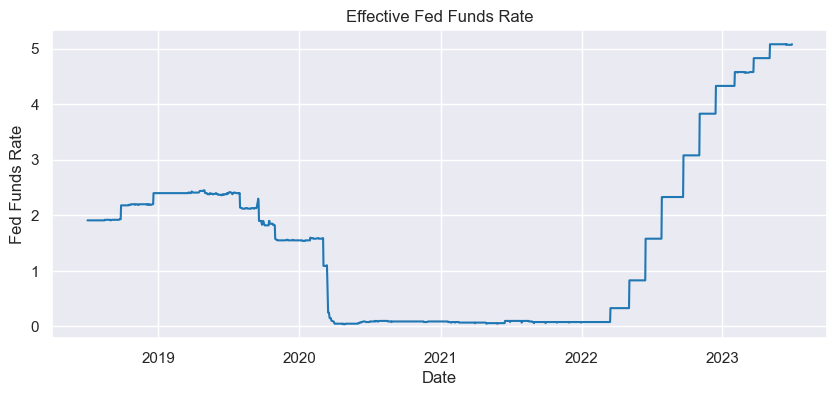

In [180]:
plt.figure(figsize = [10,4])
plt.plot(pd.read_pickle("macro_factors.pkl")[["EFFR"]])
plt.title("Effective Fed Funds Rate")
plt.xlabel("Date")
plt.ylabel("Fed Funds Rate")
plt.show()

In [ ]:
p